<a href="https://colab.research.google.com/github/stevekhkim/KaggleStruggle/blob/main/nyc_taxi_trip_duration_eda_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
# cd '/content/gdrive/MyDrive/Data Analysis/캐글 필사/01. nyc_taxi_trip_duration/data'

In [3]:
# !unzip -qq "/content/gdrive/MyDrive/Data Analysis/캐글 필사/01. nyc_taxi_trip_duration/data/nyc-taxi-trip-duration.zip"

In [4]:
# !unzip -qq "/content/gdrive/MyDrive/Data Analysis/캐글 필사/01. nyc_taxi_trip_duration/data/train.zip"
# !unzip -qq "/content/gdrive/MyDrive/Data Analysis/캐글 필사/01. nyc_taxi_trip_duration/data/test.zip"
# !unzip -qq "/content/gdrive/MyDrive/Data Analysis/캐글 필사/01. nyc_taxi_trip_duration/data/sample_submission.zip"

### 참고한 커널 자료 : [EDA + Baseline Model by AiswaryaRamachandran](https://www.kaggle.com/aiswaryaramachandran/eda-baseline-model-0-40-rmse)

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
from datetime import datetime
import calendar
from math import sin, cos, sqrt, atan2, radians
from folium import FeatureGroup, LayerControl, Map, Marker
from folium.plugins import HeatMap
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from datetime import timedelta
import datetime as dt
warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth', -1)
plt.style.use('fivethirtyeight')
import folium
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import pickle

In [6]:
train = pd.read_csv('/content/gdrive/MyDrive/Data Analysis/캐글 필사/01. nyc_taxi_trip_duration/data/train.csv')
test = pd.read_csv('/content/gdrive/MyDrive/Data Analysis/캐글 필사/01. nyc_taxi_trip_duration/data/test.csv')

__Data fields__

|No.|변수|설명|
|:---|:---|:---|
|1|id|각 여행에 대한 고유 id|
|2|vendor_id|주행기록과 연결된 제공자를 나타내는 코드|
|3|pickup_datetime|미터기가 작동된 날짜 및 시간|
|4|dropoff_datetime|미터기가 해제된 날짜 및 시간|
|5|passenger_count|차량 승객 수(택시기사 입력값)|
|6|pickup_longitude|미터기가 작동된 시점의 경도|
|7|pickup_latitude|미터기가 작동된 시점의 위도|
|8|dropoff_longitude|미터기가 해제된 시점의 경도|
|9|dropoff_latitude|미터기가 해제된 시점의 위도|
|10|store_and_fwd_flag|이 플래그는 차량이 서버와 연결되지 않았기 때문에 공급업체에 전송하기 전에 트립 레코드를 차량 메모리에 보관했는지 여부를 표시함|
|11|trip_duration|여행기간(초)|

In [7]:
train.shape

(1458644, 11)

In [8]:
test.shape

(625134, 9)

In [9]:
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


__가설__
- 탑승 시간대/위치(위도/경도)에 따라 여행기간의 특성 예측할 수 있지 않을까?
- 탑승 승객수가 여행기간의 영향을 미칠 수 있을까?

In [10]:
test.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag
0,id3004672,1,2016-06-30 23:59:58,1,-73.988129,40.732029,-73.990173,40.756680,N
1,id3505355,1,2016-06-30 23:59:53,1,-73.964203,40.679993,-73.959808,40.655403,N
2,id1217141,1,2016-06-30 23:59:47,1,-73.997437,40.737583,-73.986160,40.729523,N
3,id2150126,2,2016-06-30 23:59:41,1,-73.956070,40.771900,-73.986427,40.730469,N
4,id1598245,1,2016-06-30 23:59:33,1,-73.970215,40.761475,-73.961510,40.755890,N


목적변수가 trip_duration이기 때문에 test 데이터셋의 trip_duration, dropoff_datetime 컬럼이 존재하지 않는다.

In [11]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1458644 non-null  object 
 1   vendor_id           1458644 non-null  int64  
 2   pickup_datetime     1458644 non-null  object 
 3   dropoff_datetime    1458644 non-null  object 
 4   passenger_count     1458644 non-null  int64  
 5   pickup_longitude    1458644 non-null  float64
 6   pickup_latitude     1458644 non-null  float64
 7   dropoff_longitude   1458644 non-null  float64
 8   dropoff_latitude    1458644 non-null  float64
 9   store_and_fwd_flag  1458644 non-null  object 
 10  trip_duration       1458644 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


### Convert to appropriate datatype
convert pickup datetime and dropoff datetime into date-time object

In [12]:
train['pickup_datetime'] = pd.to_datetime(train['pickup_datetime'], format='%Y-%m-%d %H:%M:%S')
train['dropoff_datetime'] = pd.to_datetime(train['dropoff_datetime'], format='%Y-%m-%d %H:%M:%S')
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [13]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   id                  1458644 non-null  object        
 1   vendor_id           1458644 non-null  int64         
 2   pickup_datetime     1458644 non-null  datetime64[ns]
 3   dropoff_datetime    1458644 non-null  datetime64[ns]
 4   passenger_count     1458644 non-null  int64         
 5   pickup_longitude    1458644 non-null  float64       
 6   pickup_latitude     1458644 non-null  float64       
 7   dropoff_longitude   1458644 non-null  float64       
 8   dropoff_latitude    1458644 non-null  float64       
 9   store_and_fwd_flag  1458644 non-null  object        
 10  trip_duration       1458644 non-null  int64         
dtypes: datetime64[ns](2), float64(4), int64(3), object(2)
memory usage: 122.4+ MB


### Are there any missing values in the data?

In [14]:
train.isnull().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

### What is the time period of the dataset?

In [15]:
print("Min pickup time:", min(train["pickup_datetime"]))
print("Max pickup time:", max(train['pickup_datetime']))

Min pickup time: 2016-01-01 00:00:17
Max pickup time: 2016-06-30 23:59:39


The data has 6 months of taxi trip data, from Jan to June 2016

### Create new day, month, hour into from Pickup time

In [16]:
train['pickup_date'] = train['pickup_datetime'].dt.date
train['pickup_day'] = train['pickup_datetime'].dt.day
train['pickup_hour'] = train['pickup_datetime'].dt.hour
train['pickup_day_of_week'] = train['pickup_datetime'].dt.day_name()

In [17]:
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_date,pickup_day,pickup_hour,pickup_day_of_week
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,2016-03-14,14,17,Monday
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,2016-06-12,12,0,Sunday
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,2016-01-19,19,11,Tuesday
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,2016-04-06,6,19,Wednesday
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,2016-03-26,26,13,Saturday


In [18]:
train['pickup_date'] = train['pickup_datetime'].dt.date
train['pickup_day'] = train['pickup_datetime'].apply(lambda x:x.day)  # dt.day와 어떤 차이가 있을까?
train['pickup_hour'] = train['pickup_datetime'].apply(lambda x:x.hour)  # dt.hour와 어떤 차이가 있을까?
train['pickup_day_of_week'] = train['pickup_datetime'].apply(lambda x:calendar.day_name[x.weekday()])
train['dropoff_date'] = train['dropoff_datetime'].dt.date
train['dropoff_day'] = train['dropoff_datetime'].apply(lambda x:x.day)
train['dropoff_hour'] = train['dropoff_datetime'].apply(lambda x:x.hour)
train['dropoff_day_of_week'] = train['dropoff_datetime'].apply(lambda x:calendar.day_name[x.weekday()])

In [19]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 19 columns):
 #   Column               Non-Null Count    Dtype         
---  ------               --------------    -----         
 0   id                   1458644 non-null  object        
 1   vendor_id            1458644 non-null  int64         
 2   pickup_datetime      1458644 non-null  datetime64[ns]
 3   dropoff_datetime     1458644 non-null  datetime64[ns]
 4   passenger_count      1458644 non-null  int64         
 5   pickup_longitude     1458644 non-null  float64       
 6   pickup_latitude      1458644 non-null  float64       
 7   dropoff_longitude    1458644 non-null  float64       
 8   dropoff_latitude     1458644 non-null  float64       
 9   store_and_fwd_flag   1458644 non-null  object        
 10  trip_duration        1458644 non-null  int64         
 11  pickup_date          1458644 non-null  object        
 12  pickup_day           1458644 non-null  int64         
 1

### Round lat lng to 3 decimal places

In [20]:
# 위도, 경도 변수를 소수점 이하 3자리까지 반올림
train['pickup_latitude_round3'] = train['pickup_latitude'].apply(lambda x: round(x,3))
train['pickup_longitude_round3'] = train['pickup_longitude'].apply(lambda x: round(x,3))
train['dropoff_latitude_round3'] = train['dropoff_latitude'].apply(lambda x: round(x,3))
train['dropoff_longitude_round3'] = train['dropoff_longitude'].apply(lambda x: round(x,3))

train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_date,pickup_day,pickup_hour,pickup_day_of_week,dropoff_date,dropoff_day,dropoff_hour,dropoff_day_of_week,pickup_latitude_round3,pickup_longitude_round3,dropoff_latitude_round3,dropoff_longitude_round3
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,2016-03-14,14,17,Monday,2016-03-14,14,17,Monday,40.768,-73.982,40.766,-73.965
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,2016-06-12,12,0,Sunday,2016-06-12,12,0,Sunday,40.739,-73.980,40.731,-73.999
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,2016-01-19,19,11,Tuesday,2016-01-19,19,12,Tuesday,40.764,-73.979,40.710,-74.005
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,2016-04-06,6,19,Wednesday,2016-04-06,6,19,Wednesday,40.720,-74.010,40.707,-74.012
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,2016-03-26,26,13,Saturday,2016-03-26,26,13,Saturday,40.793,-73.973,40.783,-73.973


### Based on Latitude and Longitude get the distance of the trip in km

In [21]:
# 위도, 경도 변ㄴ수를 사용하요 km 단위의 거리 계산
def calculateDistance(row):
  R = 6373.0  # approximate radius of earth in km
  pickup_lat = radians(row['pickup_latitude'])
  pickup_lon = radians(row['pickup_longitude'])
  dropoff_lat = radians(row['dropoff_latitude'])
  dropoff_lon = radians(row['dropoff_longitude'])
  dlon = dropoff_lon - pickup_lon
  dlat = dropoff_lat - pickup_lat
  
  a = sin(dlat / 2)**2 + cos(pickup_lat) * cos(dropoff_lat) * sin(dlon / 2)**2
  c = 2 * atan2(sqrt(a), sqrt(1 - a))
  distance = R * c
  return distance

In [22]:
train['trip_distance'] = train.apply(lambda row:calculateDistance(row), axis=1)
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_date,pickup_day,pickup_hour,pickup_day_of_week,dropoff_date,dropoff_day,dropoff_hour,dropoff_day_of_week,pickup_latitude_round3,pickup_longitude_round3,dropoff_latitude_round3,dropoff_longitude_round3,trip_distance
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,2016-03-14,14,17,Monday,2016-03-14,14,17,Monday,40.768,-73.982,40.766,-73.965,1.498991
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,2016-06-12,12,0,Sunday,2016-06-12,12,0,Sunday,40.739,-73.980,40.731,-73.999,1.806074
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,2016-01-19,19,11,Tuesday,2016-01-19,19,12,Tuesday,40.764,-73.979,40.710,-74.005,6.387103
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,2016-04-06,6,19,Wednesday,2016-04-06,6,19,Wednesday,40.720,-74.010,40.707,-74.012,1.485965
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,2016-03-26,26,13,Saturday,2016-03-26,26,13,Saturday,40.793,-73.973,40.783,-73.973,1.188962


In [23]:
train['trip_duration_in_hour'] = train['trip_duration'].apply(lambda x: x/3600)
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_date,pickup_day,pickup_hour,pickup_day_of_week,dropoff_date,dropoff_day,dropoff_hour,dropoff_day_of_week,pickup_latitude_round3,pickup_longitude_round3,dropoff_latitude_round3,dropoff_longitude_round3,trip_distance,trip_duration_in_hour
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,2016-03-14,14,17,Monday,2016-03-14,14,17,Monday,40.768,-73.982,40.766,-73.965,1.498991,0.126389
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,2016-06-12,12,0,Sunday,2016-06-12,12,0,Sunday,40.739,-73.980,40.731,-73.999,1.806074,0.184167
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,2016-01-19,19,11,Tuesday,2016-01-19,19,12,Tuesday,40.764,-73.979,40.710,-74.005,6.387103,0.590000
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,2016-04-06,6,19,Wednesday,2016-04-06,6,19,Wednesday,40.720,-74.010,40.707,-74.012,1.485965,0.119167
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,2016-03-26,26,13,Saturday,2016-03-26,26,13,Saturday,40.793,-73.973,40.783,-73.973,1.188962,0.120833


### Exploratory Analysis

Text(0.5, 0, 'Trip Duration (in hour)')

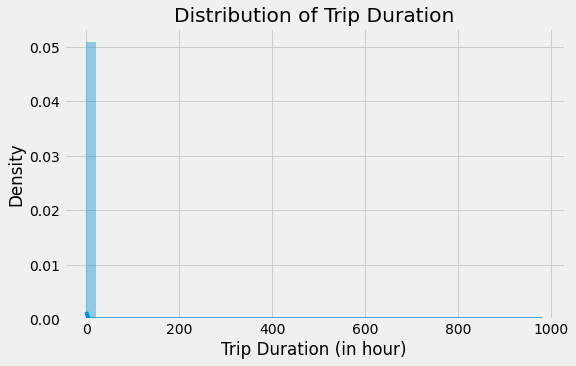

In [24]:
plt.figure(figsize=(8,5))
sns.distplot(train['trip_duration_in_hour']).set_title("Distribution of Trip Duration")
plt.xlabel("Trip Duration (in hour)")

There are trip duration greater than 24 hours. We will have to investigate this

In [25]:
outlier_trip_duration = train.loc[train['trip_duration_in_hour'] > 24]
outlier_trip_duration

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_date,pickup_day,pickup_hour,pickup_day_of_week,dropoff_date,dropoff_day,dropoff_hour,dropoff_day_of_week,pickup_latitude_round3,pickup_longitude_round3,dropoff_latitude_round3,dropoff_longitude_round3,trip_distance,trip_duration_in_hour
355003,id1864733,1,2016-01-05 00:19:42,2016-01-27 11:08:38,1,-73.789650,40.643559,-73.956810,40.773087,N,1939736,2016-01-05,5,0,Tuesday,2016-01-27,27,11,Wednesday,40.644,-73.790,40.773,-73.957,20.154989,538.815556
680594,id0369307,1,2016-02-13 22:38:00,2016-03-08 15:57:38,2,-73.921677,40.735252,-73.984749,40.759979,N,2049578,2016-02-13,13,22,Saturday,2016-03-08,8,15,Tuesday,40.735,-73.922,40.760,-73.985,5.984365,569.327222
924150,id1325766,1,2016-01-05 06:14:15,2016-01-31 01:01:07,1,-73.983788,40.742325,-73.985489,40.727676,N,2227612,2016-01-05,5,6,Tuesday,2016-01-31,31,1,Sunday,40.742,-73.984,40.728,-73.985,1.635641,618.781111
978383,id0053347,1,2016-02-13 22:46:52,2016-03-25 18:18:14,1,-73.783905,40.648632,-73.978271,40.750202,N,3526282,2016-02-13,13,22,Saturday,2016-03-25,25,18,Friday,40.649,-73.784,40.750,-73.978,19.906909,979.522778


There are 4 records which have very high trip duration, but the distance travelled is very low. These are outliers. But is there any particular location to which these trips begin or end? Trip duration is also skewed, so let us take log transformation.

We will not remove these from the analysis, because they might be a part of test data as well

Text(0.5, 1.0, 'Distribution of trip duration (sec) in Log Scale')

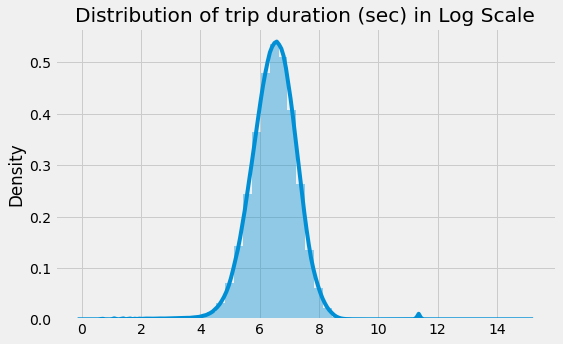

In [26]:
plt.figure(figsize=(8,5))
sns.distplot(np.log(train['trip_duration'].values)).set_title("Distribution of Trip Duration")
plt.title("Distribution of trip duration (sec) in Log Scale")

Log transformation of the trip duration results in a normal distribution. Most trips are between 54 sec (exp(4)) and 2980 sec (exp(8)) . This indicates that most trip are withing one hour. But, there are trips which are less than a minute and need to be explored in detail. There are trips lasting for 100 hours which is weird as the taxi rides are within New York

### Heatmap of common locations from where pickup and dropoff occurs

In [27]:
pickup = train.groupby(['pickup_latitude_round3', 'pickup_longitude_round3'])['id'].count().reset_index().rename(columns={'id':'Num_Trips'})

In [28]:
pickup.head()

,pickup_latitude_round3,pickup_longitude_round3,Num_Trips
0,34.360,-65.848,1
1,34.712,-75.354,1
2,35.082,-71.800,1
3,35.310,-72.074,1
4,36.029,-77.441,1


In [29]:
pickup_map = folium.Map(location = [40.730610, -73.935242], zoom_start = 10,)
#print(pickup.shape)
### For each pickup point add a circlemarker
'''
for index, row in pickup.iterrows():
    
    folium.CircleMarker([row['pickup_latitude_round3'], row['pickup_longitude_round3']],
                        radius=3,
                        
                        fill_color="#3db7e4", 
                        fill_opacity=0.9
                       ).add_to(pickup_map)
    count=count + 1


'''

hm_wide = HeatMap( list(zip(pickup.pickup_latitude_round3.values, 
                            pickup.pickup_longitude_round3.values,
                            pickup.Num_Trips.values)),
                  min_opacity=0.2, radius=5, blur=15, max_zoom=1
                  )
pickup_map.add_child(hm_wide)

pickup_map

(-74.03, -73.75)

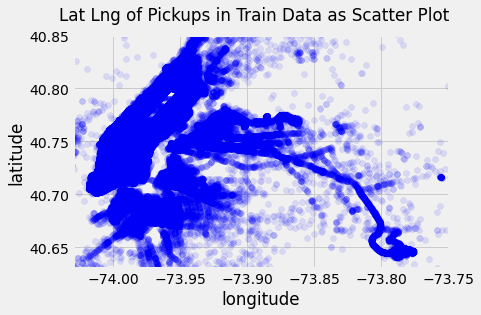

In [30]:
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)
fig, ax = plt.subplots(ncols=1, sharex=True, sharey=True)
ax.scatter(train['pickup_longitude'], train['pickup_latitude'], color='blue', label='train', alpha=0.1)

fig.suptitle('Lat Lng of Pickups in Train Data as Scatter Plot')

ax.set_ylabel('latitude')
ax.set_xlabel('longitude')
plt.ylim(city_lat_border)
plt.xlim(city_long_border)

This graph clearly shows heavy density of pickups near JFK

In [31]:
drop = train.groupby(['dropoff_latitude_round3', 'dropoff_longitude_round3'])['id'].count().reset_index().rename(columns={'id':'Num_Trips'})

In [32]:
drop.head()

,dropoff_latitude_round3,dropoff_longitude_round3,Num_Trips
0,32.181,-73.835,1
1,34.360,-65.848,1
2,35.174,-72.022,1
3,36.029,-77.441,1
4,36.119,-68.778,1


In [33]:
drop_map = folium.Map(location = [40.730610, -73.935242], zoom_start = 10,)
#print(pickup.shape)
### For each pickup point add a circlemarker
'''
for index, row in pickup.iterrows():
    
    folium.CircleMarker([row['pickup_latitude_round3'], row['pickup_longitude_round3']],
                        radius=3,
                        
                        fill_color="#3db7e4", 
                        fill_opacity=0.9
                       ).add_to(pickup_map)
    count=count + 1


'''

hm_wide = HeatMap( list(zip(drop.dropoff_latitude_round3.values, 
                            drop.dropoff_longitude_round3.values,
                            drop.Num_Trips.values)),
                  min_opacity=0.2, radius=5, blur=15, max_zoom=1
                  )
drop_map.add_child(hm_wide)

drop_map

Dropoff Heatmap is similar to pickup

### heatmap of trip duration, when pickup originates from a point

In [34]:
pickup = train.groupby(['pickup_latitude_round3', 'pickup_longitude_round3'])['trip_duration'].mean().reset_index().rename(columns={'trip_duration':'Avg_Trip_duration'})

In [35]:
pickup.head()

,pickup_latitude_round3,pickup_longitude_round3,Avg_Trip_duration
0,34.360,-65.848,961.0
1,34.712,-75.354,875.0
2,35.082,-71.800,611.0
3,35.310,-72.074,317.0
4,36.029,-77.441,782.0


In [36]:
pickup_map = folium.Map(location = [40.730610, -73.935242], zoom_start = 10,)

hm_wide = HeatMap( list(zip(pickup.pickup_latitude_round3.values,
                            pickup.pickup_longitude_round3.values,
                            pickup.Avg_Trip_duration.values)),
                  min_opacity=0.2, radius=7, blur=15, max_zoom=1
                  )

pickup_map.add_child(hm_wide)

pickup_map

The average trip duration, when trip originates from JFK is higher. If we zoom in, we can see that after the Manhattan, The pickups from JFK tend to have higher trip duration

### Which hours are pickup and dropoff higher?

Text(0.5, 1.0, 'Pickup Hours Distribution')

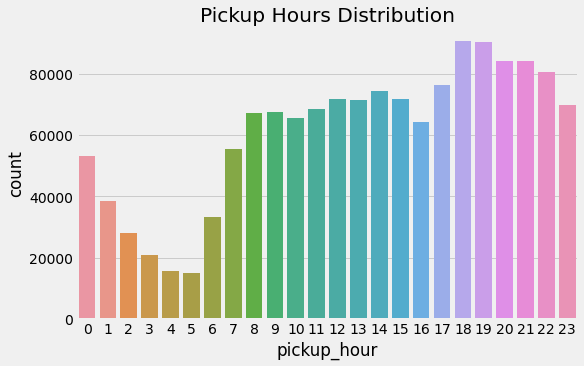

In [37]:
plt.figure(figsize=(8,5))
sns.countplot(x=train['pickup_hour']).set_title("Pickup Hours Distribution")

The pickups are much lower in the early mornings. Most pickups are around highest between 6 to 8 pm

Text(0.5, 1.0, 'Dropoff Hours Distribution')

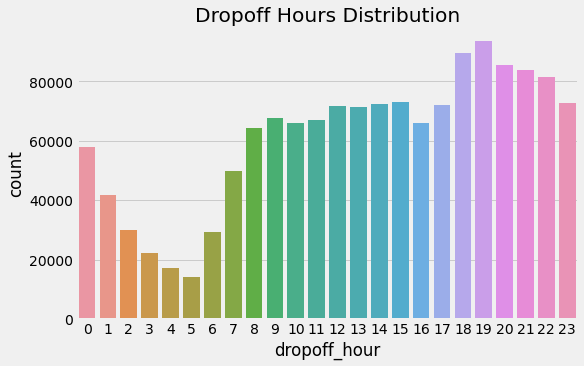

In [38]:
plt.figure(figsize=(8,5))
sns.countplot(x=train['dropoff_hour']).set_title("Dropoff Hours Distribution")

Distribution of dropoff hour also very similar to pickup hour

### Pickups over the entire time period

Text(0.5, 1.0, 'Distribution of Pickups over time')

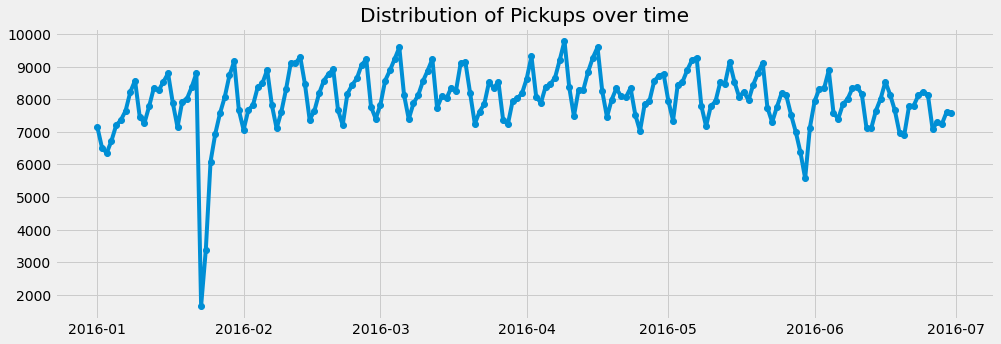

In [39]:
plt.figure(figsize=(15,5))
plt.plot(train.groupby(['pickup_date']).count()[['id']], 'o-', label='train')

plt.title("Distribution of Pickups over time")

There is a drop seen in the number of pick ups in end the January 2016

### What is the distribution of Trip distance

Text(0.5, 0, 'Trip Distance (log)')

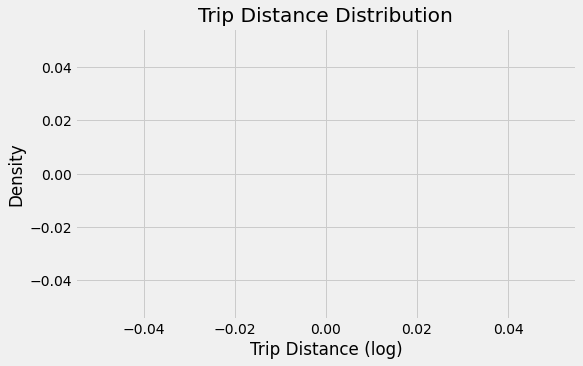

In [40]:
plt.figure(figsize=(8,5))
sns.kdeplot(np.log(train['trip_distance'].values)).set_title("Trip Distance Distribution")
plt.xlabel("Trip Distance (log)")

### Trip Duration vs Trip Distance

Text(0, 0.5, 'Trip Duration (log scale)')

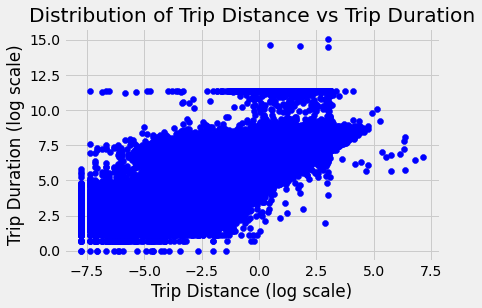

In [41]:
plt.scatter(np.log(train['trip_distance'].values), np.log(train['trip_duration'].values),
              color='blue', label='train')
plt.title("Distribution of Trip Distance vs Trip Duration")
plt.xlabel("Trip Distance (log scale)")
plt.ylabel("Trip Duration (log scale)")

### Is the trip duration higher at different hours?

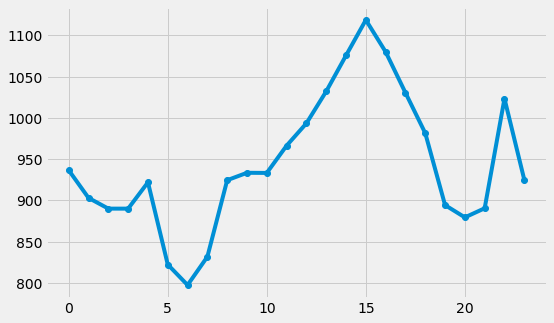

In [42]:
avg_duration_hour = train.groupby(['pickup_hour'])['trip_duration'].mean().reset_index().rename(columns={'trip_duration':'avg_trip_duration'})
plt.figure(figsize=(8,5))
plt.plot(train.groupby(['pickup_hour'])['trip_duration'].mean(), 'o-')

Trip duration increases between 10 to 15 hours.

### Distribution of Pickups across Days

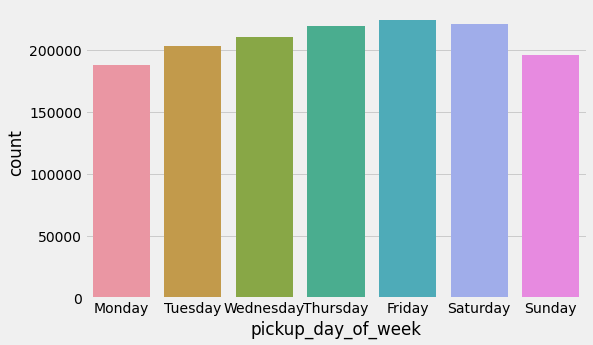

In [43]:
plt.figure(figsize=(8,5))
sns.countplot(train['pickup_day_of_week'], order=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday'])
# order = 사용 시 요일 순으로 정렬 가능

The number of pickups are very low on Monday. From Tuesday to Friday the number of pickups keep increasing

### Avg Trip Duration over Days of week

In [44]:
avg_duration_day = train.groupby(['pickup_day_of_week'])['trip_duration'].mean().reset_index().rename(columns={'trip_duration':'avg_trip_duration'})

In [45]:
avg_duration_day.head()

,pickup_day_of_week,avg_trip_duration
0,Friday,990.224200
1,Monday,897.947839
2,Saturday,948.051175
3,Sunday,901.639395
4,Thursday,1006.528654


Text(0.5, 1.0, 'Avg Trip Duration vs Pickup Days of Week')

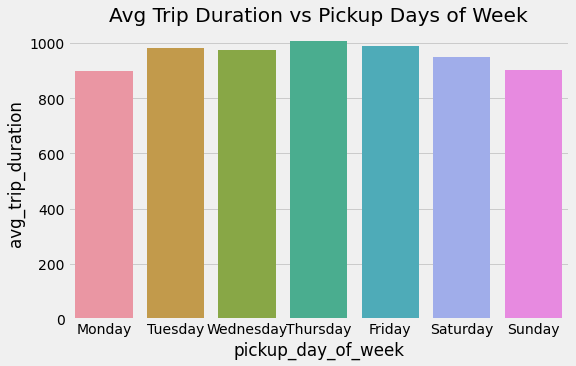

In [46]:
plt.figure(figsize=(8,5))
sns.barplot(x='pickup_day_of_week', y='avg_trip_duration', data=avg_duration_day, order=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday']).set_title("Avg Trip Duration vs Pickup Days of Week")

The highest average trip duration is on Thursday.

### Create a calculated  filed Bearing
Bearing measures the direction of travel The formula is: θ = atan2( sin Δλ ⋅ cos φ2 , cos φ1 ⋅ sin φ2 − sin φ1 ⋅ cos φ2 ⋅ cos Δλ ) λ is the longitude

In [47]:
def calculateBearing(lat1, lng1, lat2, lng2):
    R = 6371
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))

In [48]:
train['bearing']=train.apply(lambda row:calculateBearing(row['pickup_latitude_round3'],row['pickup_longitude_round3'],row['dropoff_latitude_round3'],row['dropoff_longitude_round3']),axis=1)

### Distribution of Bearing

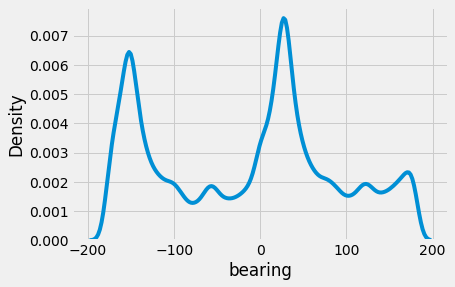

In [49]:
sns.kdeplot(train['bearing'])

### Bearing vs Trip Duration

Text(0, 0.5, 'Trip Duration (log sclae')

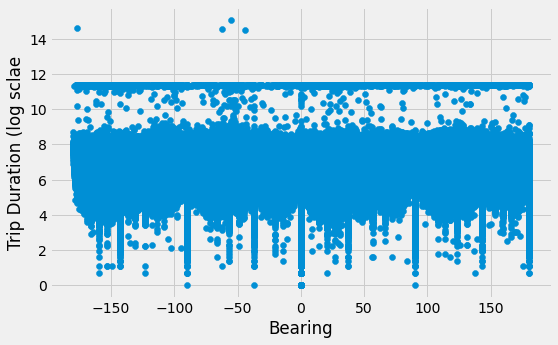

In [50]:
plt.figure(figsize=(8,5))
plt.scatter(train['bearing'].values, y=np.log(train['trip_duration'].values))
plt.xlabel("Bearing")
plt.ylabel("Trip Duration (log sclae")

The outliers in trip duration are all around bearing -50 degrees

### Distribution of Store and FWD Flag

In [51]:
train['store_and_fwd_flag'].value_counts()

N    1450599
Y    8045   
Name: store_and_fwd_flag, dtype: int64

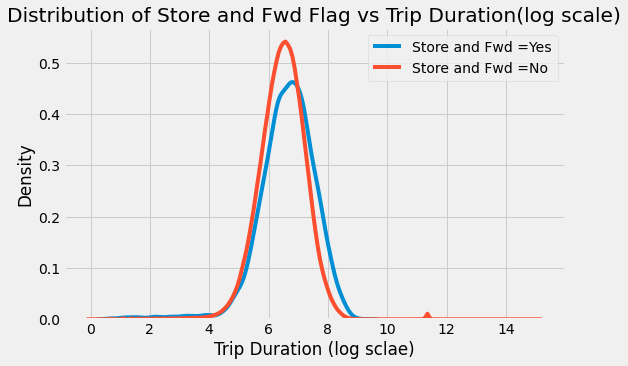

In [52]:
plt.figure(figsize=(8,5))
sns.kdeplot(np.log(train.loc[train['store_and_fwd_flag'] == 'Y', 'trip_duration'].values), label= 'Store and Fwd =Yes')
sns.kdeplot(np.log(train.loc[train['store_and_fwd_flag'] == 'N', 'trip_duration'].values), label= 'Store and Fwd =No')

plt.title("Distribution of Store and Fwd Flag vs Trip Duration(log scale)")
plt.xlabel('Trip Duration (log sclae)')
plt.ylabel('Density')
plt.legend()

### Group Locations into cluster
This will help creating neighbourhoods. And pickups from certain neightbourhoods may have a longer trip duration

(-74.03, -73.75)

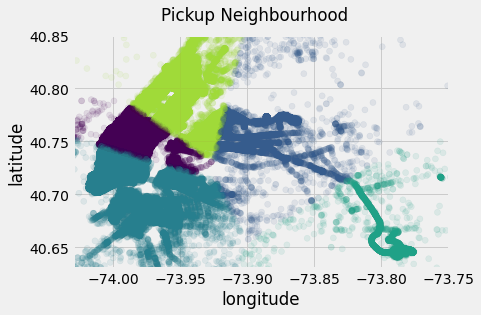

In [53]:
coords = np.vstack((train[['pickup_latitude', 'pickup_longitude']].values, 
                    train[['dropoff_latitude', 'dropoff_longitude']].values,
                    test[['pickup_latitude', 'pickup_longitude']].values,
                    test[['dropoff_latitude', 'dropoff_longitude']].values))
kmeans = KMeans(n_clusters=8, random_state=0).fit(coords)
train.loc[:, 'pickup_neighbourhood'] = kmeans.predict(train[['pickup_latitude', 'pickup_longitude']])
train.loc[:, 'dropoff_neighbourhood'] = kmeans.predict(train[['dropoff_latitude', 'dropoff_longitude']])
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)
fig, ax = plt.subplots(ncols=1, sharex=True, sharey=True)
ax.scatter(train['pickup_longitude'], train['pickup_latitude'],
           c=train['pickup_neighbourhood'], label='train', alpha=0.1)

fig.suptitle('Pickup Neighbourhood')

ax.set_ylabel('latitude')
ax.set_xlabel('longitude')
plt.ylim(city_lat_border)
plt.xlim(city_long_border)

### Number of pickups in each neighbourhood

Text(0.5, 1.0, 'Distribution of Number of Pickups across Neighbourhoods')

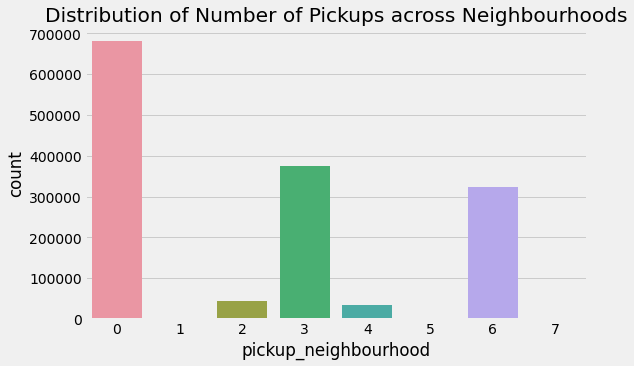

In [54]:
plt.figure(figsize=(8,5))
sns.countplot(train['pickup_neighbourhood']).set_title("Distribution of Number of Pickups across Neighbourhoods")

Text(0.5, 1.0, 'Avg Trip Duration vs Neighbourhood')

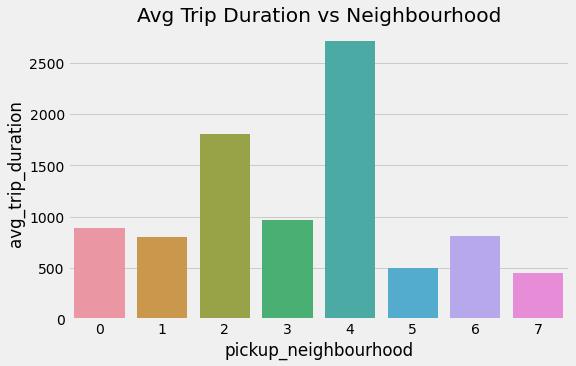

In [55]:
avg_duration_neighbourhood = train.groupby(['pickup_neighbourhood'])['trip_duration'].mean().reset_index().rename(columns={'trip_duration':'avg_trip_duration'})
plt.figure(figsize=(8,5))
sns.barplot(x='pickup_neighbourhood', y='avg_trip_duration', data=avg_duration_neighbourhood).set_title("Avg Trip Duration vs Neighbourhood")

Neighbourhood 4 has very high average Trip duration, though Neighbourhood 0 has majority of pickups

### Distribution of Average speed

In [56]:
train['avg_speed_kph'] = train['trip_distance'] / train['trip_duration_in_hour']
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_date,pickup_day,pickup_hour,pickup_day_of_week,dropoff_date,dropoff_day,dropoff_hour,dropoff_day_of_week,pickup_latitude_round3,pickup_longitude_round3,dropoff_latitude_round3,dropoff_longitude_round3,trip_distance,trip_duration_in_hour,bearing,pickup_neighbourhood,dropoff_neighbourhood,avg_speed_kph
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,2016-03-14,14,17,Monday,2016-03-14,14,17,Monday,40.768,-73.982,40.766,-73.965,1.498991,0.126389,98.823984,0,6,11.860150
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,2016-06-12,12,0,Sunday,2016-06-12,12,0,Sunday,40.739,-73.980,40.731,-73.999,1.806074,0.184167,-119.053505,0,3,9.806736
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,2016-01-19,19,11,Tuesday,2016-01-19,19,12,Tuesday,40.764,-73.979,40.710,-74.005,6.387103,0.590000,-159.948291,0,3,10.825598
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,2016-04-06,6,19,Wednesday,2016-04-06,6,19,Wednesday,40.720,-74.010,40.707,-74.012,1.485965,0.119167,-173.347990,3,3,12.469634
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,2016-03-26,26,13,Saturday,2016-03-26,26,13,Saturday,40.793,-73.973,40.783,-73.973,1.188962,0.120833,180.000000,6,6,9.839682


Text(0.5, 1.0, 'Distribution of Average Speed (in kph)')

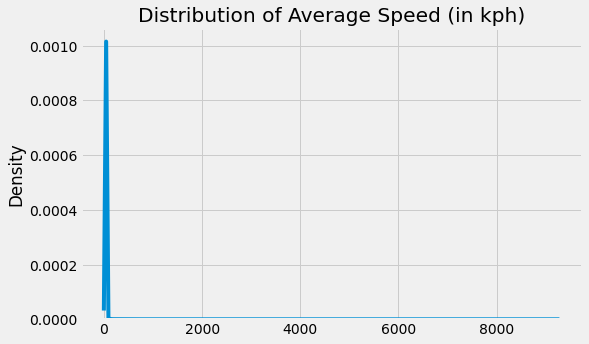

In [57]:
plt.figure(figsize=(8,5))
sns.kdeplot(train['avg_speed_kph'].values).set_title("Distribution of Average Speed (in kph)")

In [58]:
print("Average speed is",np.mean(train['avg_speed_kph']),"kph") #The average speed is 14 kmph

Average speed is 14.427736738458588 kph


### Average Speed across days of week - this is indication of traffic speed.

Text(0.5, 1.0, 'Avg Speed (kph) vs Pickup Days of Week')

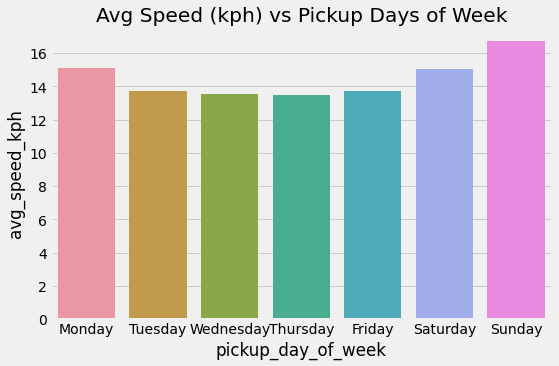

In [59]:
avg_speed_per_day = train.groupby(['pickup_day_of_week'])['avg_speed_kph'].mean().reset_index()
plt.figure(figsize=(8,5))
sns.barplot(x='pickup_day_of_week', y='avg_speed_kph', data=avg_speed_per_day, order=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday']).set_title("Avg Speed (kph) vs Pickup Days of Week")

The average speed is higher on sunday and monday.

### Feature Engineering on Test Data

In [60]:
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_date,pickup_day,pickup_hour,pickup_day_of_week,dropoff_date,dropoff_day,dropoff_hour,dropoff_day_of_week,pickup_latitude_round3,pickup_longitude_round3,dropoff_latitude_round3,dropoff_longitude_round3,trip_distance,trip_duration_in_hour,bearing,pickup_neighbourhood,dropoff_neighbourhood,avg_speed_kph
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,2016-03-14,14,17,Monday,2016-03-14,14,17,Monday,40.768,-73.982,40.766,-73.965,1.498991,0.126389,98.823984,0,6,11.860150
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,2016-06-12,12,0,Sunday,2016-06-12,12,0,Sunday,40.739,-73.980,40.731,-73.999,1.806074,0.184167,-119.053505,0,3,9.806736
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,2016-01-19,19,11,Tuesday,2016-01-19,19,12,Tuesday,40.764,-73.979,40.710,-74.005,6.387103,0.590000,-159.948291,0,3,10.825598
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,2016-04-06,6,19,Wednesday,2016-04-06,6,19,Wednesday,40.720,-74.010,40.707,-74.012,1.485965,0.119167,-173.347990,3,3,12.469634
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,2016-03-26,26,13,Saturday,2016-03-26,26,13,Saturday,40.793,-73.973,40.783,-73.973,1.188962,0.120833,180.000000,6,6,9.839682


In [61]:
test.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag
0,id3004672,1,2016-06-30 23:59:58,1,-73.988129,40.732029,-73.990173,40.756680,N
1,id3505355,1,2016-06-30 23:59:53,1,-73.964203,40.679993,-73.959808,40.655403,N
2,id1217141,1,2016-06-30 23:59:47,1,-73.997437,40.737583,-73.986160,40.729523,N
3,id2150126,2,2016-06-30 23:59:41,1,-73.956070,40.771900,-73.986427,40.730469,N
4,id1598245,1,2016-06-30 23:59:33,1,-73.970215,40.761475,-73.961510,40.755890,N


In [62]:
test['pickup_datetime'] = pd.to_datetime(test['pickup_datetime'],format='%Y-%m-%d %H:%M:%S')
test['pickup_date'] = test['pickup_datetime'].dt.date
test['pickup_day'] = test['pickup_datetime'].apply(lambda x: x.day)
test['pickup_hour'] = test['pickup_datetime'].apply(lambda x: x.hour)
test['pickup_day_of_week'] = test['pickup_datetime'].apply(lambda x: calendar.day_name[x.weekday()])
test['pickup_latitude_round3'] = test['pickup_latitude'].apply(lambda x:round(x,3))
test['pickup_longitude_round3'] = test['pickup_longitude'].apply(lambda x:round(x,3))
test['dropoff_latitude_round3'] = test['dropoff_latitude'].apply(lambda x:round(x,3))
test['dropoff_longitude_round3'] = test['dropoff_longitude'].apply(lambda x:round(x,3))
test['trip_distance'] = test.apply(lambda row:calculateDistance(row),axis=1)
test['bearing'] = test.apply(lambda row:calculateBearing(row['pickup_latitude_round3'], row['pickup_longitude_round3'],
                                                         row['dropoff_latitude_round3'], row['dropoff_longitude_round3']), axis=1)
test.loc[:, 'pickup_neighbourhood'] = kmeans.predict(test[['pickup_latitude', 'pickup_longitude']])
test.loc[:, 'dropoff_neighbourhood'] = kmeans.predict(test[['dropoff_latitude', 'dropoff_longitude']])

In [63]:
test.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,pickup_date,pickup_day,pickup_hour,pickup_day_of_week,pickup_latitude_round3,pickup_longitude_round3,dropoff_latitude_round3,dropoff_longitude_round3,trip_distance,bearing,pickup_neighbourhood,dropoff_neighbourhood
0,id3004672,1,2016-06-30 23:59:58,1,-73.988129,40.732029,-73.990173,40.756680,N,2016-06-30,30,23,Thursday,40.732,-73.988,40.757,-73.990,2.747288,-3.467814,3,0
1,id3505355,1,2016-06-30 23:59:53,1,-73.964203,40.679993,-73.959808,40.655403,N,2016-06-30,30,23,Thursday,40.680,-73.964,40.655,-73.960,2.760105,173.079082,3,3
2,id1217141,1,2016-06-30 23:59:47,1,-73.997437,40.737583,-73.986160,40.729523,N,2016-06-30,30,23,Thursday,40.738,-73.997,40.730,-73.986,1.306565,133.820793,3,3
3,id2150126,2,2016-06-30 23:59:41,1,-73.956070,40.771900,-73.986427,40.730469,N,2016-06-30,30,23,Thursday,40.772,-73.956,40.730,-73.986,5.270742,-151.571957,6,3
4,id1598245,1,2016-06-30 23:59:33,1,-73.970215,40.761475,-73.961510,40.755890,N,2016-06-30,30,23,Thursday,40.761,-73.970,40.756,-73.962,0.961143,129.524016,0,0
